In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#データの読み込み
folder_path = '/content/drive/My Drive/dressipi_recsys2022/'
df_candidate_items = pd.read_csv(folder_path + "candidate_items.csv")
df_item_features = pd.read_csv(folder_path + "item_features.csv")
df_test_final_sessions = pd.read_csv(folder_path + "test_final_sessions.csv")
df_test_leaderboard_sessions = pd.read_csv(folder_path + "test_leaderboard_sessions.csv")
df_train_purchases = pd.read_csv(folder_path + "train_purchases.csv")
df_train_sessions = pd.read_csv(folder_path + "train_sessions.csv")

In [ ]:
#df_item_features.pivot(index='item_id', columns='feature_category_id', values='feature_value_id')
#アイテム×特徴でかぶりがあるので単純なピボットができない（カラーが青と白2つある的な）

In [5]:
print("アイテムの個数",len(df_item_features['item_id'].unique()))
print("セッション中に出てきたアイテム数",len(df_train_sessions['item_id'].unique()))
print("買われたアイテム数",len(df_train_purchases['item_id'].unique()))

アイテムの個数 23691
セッション中に出てきたアイテム数 23496
買われたアイテム数 18907


In [60]:
print("購入された商品の調査")
item_ranking_purchases = df_train_purchases.groupby('item_id').count().sort_values("session_id",ascending = False)
item_ranking_purchases['rank'] = item_ranking_purchases['session_id'].rank(ascending = False)
item_ranking_purchases = item_ranking_purchases.rename(columns={'session_id': 'count'})[['rank','count']]
print("売れ筋商品TOP10:", item_ranking_purchases.head(10))

購入された商品の調査
売れ筋商品TOP10:          rank  count
item_id             
8060      1.0   8451
26853     2.0   3829
19882     3.0   3355
8622      4.0   2745
2447      5.0   2726
4193      6.0   2416
20770     7.0   2349
18156     8.0   2308
17089     9.0   2032
1644     10.0   1879


各商品の購入回数はかなり歪な分布
各商品が購入された回数の中央値： 26.0
各商品が購入された回数の平均値： 52.89046384936796


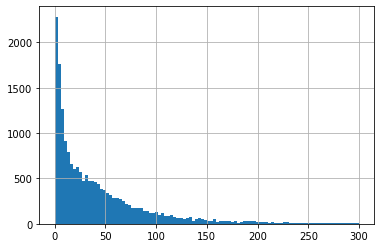

In [32]:
print("各商品の購入回数はかなり歪な分布")
print("各商品が購入された回数の中央値：",np.median(item_ranking_purchases))
print("各商品が購入された回数の平均値：",np.mean(item_ranking_purchases))
item_ranking_purchases.hist(bins = 100,range=(0, 300))
plt.show()


In [64]:
print("セッションの調査")
item_ranking_session = df_train_sessions.groupby('item_id').count().sort_values("session_id",ascending = False)
item_ranking_session['rank'] = item_ranking_session['session_id'].rank(ascending = False)
item_ranking_session = item_ranking_session.rename(columns={'session_id': 'count'})[['rank','count']]
print("閲覧商品TOP10:", item_ranking_session.head(10))

セッションの調査
閲覧商品TOP10:          rank  count
item_id             
8060      1.0  14714
26853     2.0  13192
2447      3.0   9774
1644      4.0   6955
19882     5.0   6947
7963      6.0   6464
8622      7.0   6380
17089     8.0   6345
11742     9.0   6223
18156    10.0   5908


In [66]:
print('閲覧ランキングと購入ランキングは似た商品（人気商品）が並ぶ')
item_ranking_merge = pd.merge(item_ranking_session,item_ranking_purchases, how='left', on = 'item_id')
item_ranking_merge.rename(columns={'rank_x': 'rank_session', 'rank_y': 'rank_purchases','count_x': 'count_session', 'count_y': 'count_purchases'})
print("閲覧商品_購入TOP10:", item_ranking_merge.head(10))

閲覧ランキングと購入ランキングは似た商品（人気商品）が並ぶ
閲覧商品_購入TOP10:          rank_x  count_x  rank_y  count_y
item_id                                  
8060        1.0    14714     1.0   8451.0
26853       2.0    13192     2.0   3829.0
2447        3.0     9774     5.0   2726.0
1644        4.0     6955    10.0   1879.0
19882       5.0     6947     3.0   3355.0
7963        6.0     6464    19.0   1511.0
8622        7.0     6380     4.0   2745.0
17089       8.0     6345     9.0   2032.0
11742       9.0     6223    11.0   1877.0
18156      10.0     5908     8.0   2308.0


In [131]:
print('個別の商品毎の調査')
no1_item = item_ranking_session.index[0]
print('No1商品=',no1_item)
#No1商品が買われたセッションを抜き出し
target_sessions = df_train_purchases[df_train_purchases['item_id']==no1_item]['session_id'].values
#No1商品が買われる前に閲覧されていた商品のランキング
no1_item_rank = df_train_sessions[df_train_sessions['session_id'].isin(target_sessions)].groupby('item_id').count().sort_values("date",ascending = False)\
                                                                .rename(columns={'session_id': 'count'})['count']
print('No1商品が買われる前に閲覧されていた商品のランキング')
print(no1_item_rank.head(10))

個別の商品毎の調査
No1商品= 8060
No1商品が買われる前に閲覧されていた商品のランキング
item_id
18156    1424
2447     1154
16660     986
7640      602
17239     357
9185      352
17089     329
24921     319
19882     308
8622      306
Name: count, dtype: int64


In [133]:
print('No1商品とその前に閲覧されていた商品TOP30の共通特徴量を探す')
item_list = list(no1_item_rank.head(30).index)
item_list.append(no1_item)

No1商品とその前に閲覧されていた商品TOP10の共通特徴量を探す


In [134]:
print('上位の特徴×特徴量は31商品全てに共通していた　= 特徴量として優秀')
print('イメージとして、青色・ウィメンズ・サイズM等の特徴量が上に来ている？')
feature_rank_no1 = df_item_features[df_item_features['item_id'].isin(item_list)].groupby(['feature_category_id', 'feature_value_id']).count().sort_values("item_id",ascending = False)\
                  .rename(columns={'item_id': 'count'})
print(feature_rank_no1.head(15))

上位の特徴×特徴量は11商品全てに共通していた　= 特徴量として優秀
                                      count
feature_category_id feature_value_id       
72                  75                   31
62                  801                  31
56                  365                  31
47                  123                  31
4                   618                  30
33                  36                   30
24                  588                  30
63                  861                  30
69                  885                  29
55                  267                  29
73                  544                  28
7                   394                  28
53                  6                    24
68                  351                  24
61                  462                  23


In [156]:
item_ranking_session.index[0:50]

Int64Index([ 8060, 26853,  2447,  1644, 19882,  7963,  8622, 17089, 11742,
            18156, 23088,  2072,  4028, 20770,  9184, 21616, 19912,  6736,
            26691,  7640, 17239, 27613, 21215,  2915, 18657, 24921,  4193,
             1018, 20236, 27225, 12179,  2814,  8861, 27555,   972,  4130,
            19150, 15501, 14392, 13922,  2173, 12251, 27151, 21890, 21668,
            27852, 22704, 10390,  4917, 16660],
           dtype='int64', name='item_id')

feature_category_id  feature_value_id  count  purchased_item
0                    56               365     51           16660
1                    72                75     49           16660
2                    47               123     46           16660
3                    69               885     43           16660
4                     7               394     43           16660
..                  ...               ...    ...             ...
45                   18               817      2           16660
46                   19               765      2           16660
47                   33               764      2           16660
48                   11               109      2           16660
49                   32               286      2           16660

[100 rows x 4 columns]

In [160]:
#上記のプロセスを変数化して
rank_num = 50
feature_num = 50
item_num = 50
feature_result = pd.DataFrame(columns=['feature_category_id', 'feature_value_id', 'count','purchased_item'])
for temp_item in item_ranking_session.index[0:item_num]:
  #その商品が買われたセッションを抜き出し
  target_sessions = df_train_purchases[df_train_purchases['item_id']==temp_item]['session_id'].values
  #その商品が買われる前に閲覧されていた商品のランキング
  temp_item_rank = df_train_sessions[df_train_sessions['session_id'].isin(target_sessions)].groupby('item_id').count().sort_values("date",ascending = False)\
                                                                  .rename(columns={'session_id': 'count'})['count']
  #'その商品とその前に閲覧されていた商品TOPrank_numの共通特徴量を探す'
  item_list = list(temp_item_rank.head(rank_num).index)
  item_list.append(temp_item)
  feature_rank_temp = df_item_features[df_item_features['item_id'].isin(item_list)].groupby(['feature_category_id', 'feature_value_id']).count().sort_values("item_id",ascending = False)\
                    .rename(columns={'item_id': 'count'})
  feature_rank_temp = feature_rank_temp.head(feature_num).reset_index()
  feature_rank_temp['purchased_item'] = [temp_item for i in range(len(feature_rank_temp))]
  feature_result = pd.concat([feature_result,feature_rank_temp])

In [173]:
print(len(feature_result)) # 50×50×50よりも少ない
len_df = len(feature_result)
print(feature_result.groupby(['feature_category_id']).sum().sort_values('count',ascending = False).head(30)['count']/len_df)
print('上位のfeature_categoryほど購入に直接結びついてる')

2491
feature_category_id
56    1.017664
47    0.982336
50    0.981935
72    0.979928
61    0.971497
63    0.961060
69    0.956242
4     0.955038
55    0.951827
7     0.935367
73    0.928543
68    0.923324
62    0.879165
29    0.873545
53    0.868727
24    0.853473
28    0.752308
33    0.730229
30    0.503412
17    0.247290
65    0.211963
60    0.119229
6     0.112003
45    0.110397
46    0.108792
3     0.107989
32    0.098756
5     0.097953
26    0.087515
19    0.056604
Name: count, dtype: float64
上位のfeature_categoryほど購入に直接結びついてる


In [189]:
print('上記でNo1のfeature_category_idは')
print(56, "----------------------No1 feature----------------------")
print(feature_result[feature_result['feature_category_id'] == 56].groupby('feature_value_id').sum()['count'])
print(47, "----------------------No2 feature----------------------")
print(feature_result[feature_result['feature_category_id'] == 47].groupby('feature_value_id').sum()['count'])
print(50, "----------------------No3 feature----------------------")
print(feature_result[feature_result['feature_category_id'] == 50].groupby('feature_value_id').sum()['count'])

上記でNo1のfeature_category_idは
56 ----------------------No1 feature----------------------
feature_value_id
239       2
365    2533
Name: count, dtype: int64
47 ----------------------No2 feature----------------------
feature_value_id
36      121
123    1844
218       6
273      17
512       1
516     327
549      61
720      41
842      29
Name: count, dtype: int64
50 ----------------------No3 feature----------------------
feature_value_id
76      24
128     42
130     17
164     21
212      9
240    917
317    431
328    289
643     29
708     40
737      9
901    618
Name: count, dtype: int64


In [190]:
print('売れ筋商品20商品の共通特徴量')
item_list = list(item_ranking_purchases.head(20).index)

feature_rank_no1 = df_item_features[df_item_features['item_id'].isin(item_list)].groupby(['feature_category_id', 'feature_value_id']).count().sort_values("item_id",ascending = False)\
                  .rename(columns={'item_id': 'count'})
print(feature_rank_no1.head(15))

print('上位の特徴×特徴量は20個全てに当てはまっていた')
print('かなり意外。売れ筋商品ランキングではシャツとかズボンとか混ざることが考えられ、共通特長は少なくなると思っていた')

売れ筋商品20商品の共通特徴量
                                      count
feature_category_id feature_value_id       
73                  544                  20
56                  365                  20
24                  588                  19
4                   618                  19
62                  801                  19
55                  267                  19
63                  861                  19
72                  75                   18
61                  462                  16
68                  351                  15
7                   394                  14
29                  386                  14
47                  123                  14
33                  36                   12
53                  444                  11
上位の特徴×特徴量は20個全てに当てはまっていた
かなり意外。売れ筋商品ランキングではシャツとかズボンとか混ざることが考えられ、共通特長は少なくなると思っていた
